# Assignment 2: Detecting Contradictions in Law Documents
By Tim Nahtigal and Domen Sedlar

## Setup

Please run this chunk of code and skip to the next chapter. 

In [125]:
import pandas as pd
import numpy as np
import datasets
import nltk
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from scipy.sparse import hstack
from sklearn.model_selection import RandomizedSearchCV
from tabulate import tabulate

import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD

from transformers import Trainer
from sklearn.metrics import classification_report
import os
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()
train_data_path = "./data/English dataset/train.jsonl"
test_data_path = "./data/English dataset/test.jsonl"

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Domen\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Domen\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Domen\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Domen\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [128]:
def pretty_print_report_dict(report):
	report_df = pd.DataFrame(report).transpose()
	report_df = report_df.round(3)

	class_metrics = report_df.iloc[:-3, :].copy()

	summary_metrics = report_df.iloc[-3:, :].copy()
	summary_metrics = summary_metrics.drop(columns=['support'])

	print("CLASS PERFORMANCE")
	print(tabulate(class_metrics, headers='keys', tablefmt='heavy_outline', numalign="center"))
	print()
	print("GLOBAL AVERAGES")
	print(tabulate(summary_metrics, headers='keys', tablefmt='heavy_outline', numalign="center"))

def preprocess_text(text): # Based on code from the labs
	# Tokenize the text into words
	words = word_tokenize(text.lower())  # Convert text to lowercase

	# Remove punctuation
	table = str.maketrans('', '', string.punctuation)
	words = [word.translate(table) for word in words if word.isalpha()]

	# Remove stopwords
	stop_words = set(stopwords.words('english'))
	words = [word for word in words if word not in stop_words]

	# Lemmatization
	lemmatized_words = [lemmatizer.lemmatize(word) for word in words]

	# Join the words back into a string
	preprocessed_text = ' '.join(lemmatized_words)
	return preprocessed_text

### For task 4

#### Evaluators setup

In [2]:
from sentence_transformers.evaluation import InformationRetrievalEvaluator
from collections import defaultdict

def get_ret_eval(test_dataset, name=''):
    corpus = dict(zip(test_dataset['premise'], test_dataset['premise']))
    queries = dict(zip(test_dataset['hypothesis'], test_dataset['hypothesis']))
    relevant_docs = defaultdict(list)

    for k in range(len(test_dataset)):
        if test_dataset['label'][k] > 0:
            relevant_docs[test_dataset['hypothesis'][k]].append(test_dataset['premise'][k])
    

    inf_ret_ev = InformationRetrievalEvaluator(
        queries= queries,
        corpus = corpus,
        relevant_docs = relevant_docs,
        #similarity_fn_names= ["cosine"],
        show_progress_bar=True,
        batch_size= 16,
        #main_score_function="Recall@10",
        name=name
    )

    return inf_ret_ev

In [3]:
# Custom evaluator
from sentence_transformers.evaluation import SentenceEvaluator
from collections import defaultdict
from sentence_transformers.util import cos_sim
import torch
import numpy as np
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator, SimilarityFunction
import copy

class MyRecallEval(SentenceEvaluator):
    def structure(test_dataset):
        corpus = dict(zip(test_dataset['premise'], test_dataset['premise']))
        queries = dict(zip(test_dataset['hypothesis'], test_dataset['hypothesis']))
        relevant_docs = defaultdict(list)

        for k in range(len(test_dataset)):
            if test_dataset['label'][k] > 0:
                relevant_docs[test_dataset['hypothesis'][k]].append(test_dataset['premise'][k])

        return (queries, corpus, relevant_docs)
        
    def __init__(self, data, recall_ks=[10], cluster_k=10,cluster_min_hits=1,name: str = "", main_similarity=SimilarityFunction.COSINE):
        super().__init__()
        hypotheses, premises, relevant_premises = MyRecallEval.structure(data)
        self.hypotheses = hypotheses
        self.premises = premises
        self.relevant_premises = relevant_premises
        self.recall_ks = recall_ks
        self.cluster_k = cluster_k
        self.cluster_min_hits = cluster_min_hits
        self.name = name
        self.main_similarity = SimilarityFunction.to_similarity_fn(main_similarity)
        self.greater_is_better = True
        self.primary_metric = f"recall@{max(recall_ks)}"

        self.hyp_ids = list(hypotheses.keys())
        self.hyp_ids.sort() # we want to ensure a consistent order
        self.premise_ids = list(premises.keys())

        self.hyp_mistakes_dist = {}
        for i in self.hyp_ids:
            self.hyp_mistakes_dist[i] = 0

    def get_and_clear_mistakes_info(self):
        r = copy.deepcopy(self.hyp_mistakes_dist)
        self.hyp_mistakes_dist = {}
        for i in self.hyp_ids:
            self.hyp_mistakes_dist[i] = 0
        return r

    def __call__(self, model, output_path=None, epoch=-1, steps=-1):
        hyp_texts = [self.hypotheses[h] for h in self.hyp_ids]
        prem_texts = [self.premises[p] for p in self.premise_ids]

        hyp_emb = model.encode(hyp_texts, convert_to_tensor=True, normalize_embeddings=True)
        prem_emb = model.encode(prem_texts, convert_to_tensor=True, normalize_embeddings=True)
        scores = self.main_similarity(hyp_emb, prem_emb)  # shape: [num_hyp, num_prem]

        recalls = {k: [] for k in self.recall_ks}
        normrecalls = {k: [] for k in self.recall_ks}

        cluster_success = []

        for i, hyp_id in enumerate(self.hyp_ids):
            relevant = self.relevant_premises[hyp_id]
            if not relevant:
                continue

            relevant_idx = {self.premise_ids.index(pid) for pid in relevant}

            ranked = torch.argsort(scores[i], descending=True)

            for k in self.recall_ks:
                topk = ranked[:k].tolist()
                hits = len(set(topk) & relevant_idx)
                normrecalls[k].append(hits / min(k,len(relevant_idx)))
                recalls[k].append(hits / len(relevant_idx))

            # Cluster recall
            top_cluster = ranked[: self.cluster_k].tolist()
            hits = len(set(top_cluster) & relevant_idx)
            cluster_success.append(hits >= self.cluster_min_hits)
            if hits < self.cluster_min_hits:
                self.hyp_mistakes_dist[hyp_id] += 1

        metrics = {
            f"recall@{k}": float(np.mean(recalls[k])) for k in self.recall_ks
        }

        metrics["hit_rate"] = float(np.mean(cluster_success))

        self.store_metrics_in_model_card_data(model, metrics, epoch, steps)

        if self.name:
            for key in list(metrics.keys()):
                metrics[f"{self.name}_{key}"] = metrics.pop(key)
        return metrics


In [4]:
from sentence_transformers.training_args import SentenceTransformerTrainingArguments
from sentence_transformers import SentenceTransformer
from sentence_transformers.losses import ContrastiveLoss, MultipleNegativesRankingLoss
from sentence_transformers.training_args import BatchSamplers

# 3. Define the Hyperparameter Search Space
def search_space(trial):
    return {
        'learning_rate': trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True),
        'weight_decay': trial.suggest_float("weight_decay", 0.01, 0.1),
        "warmup_ratio": trial.suggest_float("warmup_ratio", 0.05, 0.2),
        'max_grad_norm': trial.suggest_float("max_grad_norm", 0.5, 1.0, log=True),
        'num_train_epochs': trial.suggest_int("num_train_epochs", 1, 10), # ! lower when using a slower model 
    }

# 4. Define the Model Initialization
def model_init(trial):
    return SentenceTransformer("./models/jina-embeddings-v2-small-en", device="cuda")

# 5. Define the Loss Initialization
def cl_loss_init(model):
    return ContrastiveLoss(model)
def mnlr_loss_init(model):
    return MultipleNegativesRankingLoss(model)

# 6. Define the Objective Function
def hpo_compute_objective(metrics):
    print(metrics)
    return metrics["eval_sts-dev_cosine_recall@10"]

#### data

In [5]:
from datasets import Dataset, load_dataset
import pandas as pd

def get_data(valid_split=0.1):
    train_data_path = "./data/English dataset/train.jsonl"
    test_data_path = "./data/English dataset/test.jsonl"

    train_data = pd.DataFrame(load_dataset("json", data_files=train_data_path)["train"])
    test_dataset = pd.DataFrame(load_dataset("json", data_files=test_data_path)["train"])

    label_map = {"Contradiction": 1, "Entailment": 0, "NotMentioned": 0}
    train_data["label"] = train_data["label"].map(label_map)
    test_dataset["label"] = test_dataset["label"].map(label_map)

    train_data = train_data.drop("doc_id", axis=1)
    train_data = train_data.drop("key", axis=1)
    test_dataset = test_dataset.drop("doc_id", axis=1)
    test_dataset = test_dataset.drop("key", axis=1)

    train_data["label"].value_counts(normalize=True)

    ds = Dataset.from_pandas(train_data)
    ds = ds.select_columns(["hypothesis", "premise", "label"])

    dss = ds.train_test_split(valid_split)
    train_dataset = dss['train']
    valid_dataset = dss['test']
    test_dataset = Dataset.from_pandas(test_dataset)
    test_dataset = test_dataset.select_columns(["hypothesis", "premise", "label"])

    return train_dataset, valid_dataset, test_dataset

#### Setup for training

In [6]:
from sentence_transformers.losses import ContrastiveLoss
from sentence_transformers.trainer import SentenceTransformerTrainer
from sentence_transformers import SentenceTransformer
from transformers import EarlyStoppingCallback


def get_trainer(
        train_dataset, 
        valid_dataset, 
        model_init=model_init,
        loss=mnlr_loss_init, 
        args=None, 
        evaluator=None, 
        data_preprocesser=None, 
        params=None,
        trained_model_path=None,
        early_stopping=False,
        name=None
    ):
    #base_model = SentenceTransformer(model_name)
    
    #loss = loss(base_model)
    data_collator = None
    if early_stopping:
        early_stopper = [EarlyStoppingCallback(
            early_stopping_patience=5,
            early_stopping_threshold=0.05
        )]
    else:
        early_stopper = None

    if data_preprocesser is not None:
        train_dataset, data_collator = data_preprocesser(train_dataset, model_init(None), params)

    if valid_dataset is not None and evaluator is None:
        evaluator = get_ret_eval(valid_dataset)

    trainer = SentenceTransformerTrainer(
        model_init = model_init,
        train_dataset = train_dataset,
        eval_dataset = valid_dataset,
        loss = loss,
        evaluator = evaluator,
        args = args,
        data_collator = data_collator,
        callbacks=early_stopper
    )

    return trainer

In [7]:
def train(train_dataset, valid_dataset, model_kwargs):
    trainer = get_trainer(train_dataset, valid_dataset,early_stopping=False, **model_kwargs)
    trainer.train()
    trainer.model.save_pretrained(model_kwargs['trained_model_path'])

In [8]:
TRAIN = False

## Data preprocessing

In the first part of the assignment we were tasked with data preprocessing. We choose the english dataset, because many libraries for working with slovene text were outdated and resulted in dependency problems. 

In [26]:
train_data = pd.DataFrame(datasets.load_dataset("json", data_files=train_data_path)["train"])
test_data = pd.DataFrame(datasets.load_dataset("json", data_files=test_data_path)["train"])

label_map = {"Contradiction": 1, "Entailment": 0, "NotMentioned": 0}
train_data["label"] = train_data["label"].map(label_map)
test_data["label"] = test_data["label"].map(label_map)

train_data["premise"] = train_data["premise"].map(preprocess_text)
train_data["hypothesis"] = train_data["hypothesis"].map(preprocess_text)

test_data["premise"] = test_data["premise"].map(preprocess_text)
test_data["hypothesis"] = test_data["hypothesis"].map(preprocess_text)

train_data = train_data.drop("doc_id", axis=1)
train_data = train_data.drop("key", axis=1)
test_data = test_data.drop("doc_id", axis=1)
test_data = test_data.drop("key", axis=1)

print("Length of train data: ", len(train_data))
print("Length of test data: ", len(test_data))

Length of train data:  7191
Length of test data:  2091


The data is already split into train and test dataset in a 7:2 ratio. Usually we would split data closer to 10:1, but we choose to honor the original split. We also removed labels "key" and "doc_id" because we didn't need them. 

We choose to rename the values in "label" from "Contradiction" to 1, and "Entailment" and "NotMentioned" to 0. We chosen to do this because we wanted to focus only in finding contradictions, and numeric values are easier to work with when using libraries. 

In [12]:
train_data["label"].value_counts(normalize=True)

label
0    0.883048
1    0.116952
Name: proportion, dtype: float64

Here we can see that value in "label" 0 (non contradictions) are way more represented than value 1 (contradictions). This dataset is very unbalanced. There isn't a good way to show this, but we also noticed that the dataset isn't that high of a quality. There are many mostly duplicate sentences, contradictions that even for humans it's hard to make sense of and other problems.

In [37]:
longest_premise_len = max(train_data['premise'].apply(len).max(), test_data['premise'].apply(len).max())
med_premise_len = (pd.concat([train_data['premise'], test_data['premise']]).apply(len).median())
longest_hypothesis = max(train_data['hypothesis'].apply(len).max(), test_data['hypothesis'].apply(len).max())
med_hypothesis_len = (pd.concat([train_data['hypothesis'], test_data['hypothesis']]).apply(len).median())
longest_sentence_len = max(longest_premise_len, longest_hypothesis)
print("Median premise length: ", med_premise_len)
print("Median hypothesis length: ", med_hypothesis_len)
print("Longest sentence length:", longest_sentence_len)
print("---------------------------------")
mean = np.mean(train_data['premise'].apply(len))
std = np.std(train_data['premise'].apply(len))

print("Mean premise length in the train dataset: ", mean)
print("+1 std: ", mean+std)
print("+2 std: ", mean+2*std)
print("+3 std: ", mean+3*std)

Median premise length:  148.0
Median hypothesis length:  75.0
Longest sentence length: 2226
---------------------------------
Mean premise length in the train dataset:  206.30079265748853
+1 std:  456.0930735958574
+2 std:  705.8853545342262
+3 std:  955.6776354725951


While working with data we note a few things. We note that the premises are usually longer than hypothesi and that the longest sentence in the dataset is over 2000 characters long. This directly affects our model picks for task 3 and 4. 

To be more specific, the mean length of a premise in the train dataset is around 200 characters long. This fits into something like BART's 512 tokens long context window, but we would need to modify a bit less than 30% of the data, while if we choose something with context window of 1000 or more we can safely truncate the access text and still not modify 99%+ of the data. 

## Traditional ML

In second part of the assignment we were tasked to try out few of traditional machine learning classifiers. For text representation we used Tf-Idf for it's simplicity. The code below vectorizes the data into Tf-Idf embedding and stacks premises and hypothesi together to be classified. 

In [41]:
vectorizer_premise = TfidfVectorizer()
vectorizer_hypothesis = TfidfVectorizer()

train_data_vectorized = train_data.copy()

X_premise= vectorizer_premise.fit_transform(train_data["premise"])
X_hypothesis = vectorizer_hypothesis.fit_transform(train_data["hypothesis"])
train_data_vectorized = hstack([X_premise, X_hypothesis])

Y_premise = vectorizer_premise.transform(test_data["premise"])
Y_hypothesis = vectorizer_hypothesis.transform(test_data["hypothesis"])
test_data_vectorized = hstack([Y_premise, Y_hypothesis])

For each model below we are running randomized grid search for right hyper parameters. We are also using 3 fold cross validation to select the best model. The metric we are after is F1 accuracy. 

We will talk about findings at the end of the chapter as tables are self explanatory.  

### Logistic regression

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

grid_search_dict = {
	"l1_ratio": [0, 0.5, 1],
	"C": [0.1, 0.5, 1.0, 2.0, 10, 50],
	"class_weight": [None, "balanced"],
	"solver": ["saga"]
}

logreg_model = RandomizedSearchCV(LogisticRegression(max_iter=5000), grid_search_dict, n_iter=10, cv=3, scoring='f1')
logreg_model.fit(train_data_vectorized, train_data["label"])

predictions = logreg_model.predict(test_data_vectorized)

display_params = [[k, str(v)] for k, v in logreg_model.best_params_.items()]
print(tabulate(display_params, headers=["Hyperparameter", "Value"], tablefmt="heavy_outline"))

c:\Users\timna\Desktop\SkupnoAng\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\timna\Desktop\SkupnoAng\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ Hyperparameter   ┃ Value    ┃
┣━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━┫
┃ solver           ┃ saga     ┃
┃ l1_ratio         ┃ 1        ┃
┃ class_weight     ┃ balanced ┃
┃ C                ┃ 2.0      ┃
┗━━━━━━━━━━━━━━━━━━┻━━━━━━━━━━┛


c:\Users\timna\Desktop\SkupnoAng\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [43]:
report_dict = classification_report(test_data["label"], predictions, zero_division=0, output_dict=True)
pretty_print_report_dict(report_dict)

CLASS PERFORMANCE
┏━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃    ┃  precision  ┃  recall  ┃  f1-score  ┃  support  ┃
┣━━━━╋━━━━━━━━━━━━━╋━━━━━━━━━━╋━━━━━━━━━━━━╋━━━━━━━━━━━┫
┃ 0  ┃    0.982    ┃  0.966   ┃   0.974    ┃   1871    ┃
┃ 1  ┃    0.745    ┃   0.85   ┃   0.794    ┃    220    ┃
┗━━━━┻━━━━━━━━━━━━━┻━━━━━━━━━━┻━━━━━━━━━━━━┻━━━━━━━━━━━┛

GLOBAL AVERAGES
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━┓
┃              ┃  precision  ┃  recall  ┃  f1-score  ┃
┣━━━━━━━━━━━━━━╋━━━━━━━━━━━━━╋━━━━━━━━━━╋━━━━━━━━━━━━┫
┃ accuracy     ┃    0.954    ┃  0.954   ┃   0.954    ┃
┃ macro avg    ┃    0.864    ┃  0.908   ┃   0.884    ┃
┃ weighted avg ┃    0.957    ┃  0.954   ┃   0.955    ┃
┗━━━━━━━━━━━━━━┻━━━━━━━━━━━━━┻━━━━━━━━━━┻━━━━━━━━━━━━┛


### Random Forest

In [44]:
from sklearn.ensemble import RandomForestClassifier

grid_search_dict = {
	"n_estimators": [50, 100, 200],
	"max_depth": [None, 5, 10, 20],
	"min_samples_split": [2, 5, 10, 20, 50],
	"class_weight": [None, "balanced"]
}

rf_model = RandomizedSearchCV(RandomForestClassifier(random_state=67), grid_search_dict, n_iter=15, cv=3, scoring='f1')
rf_model.fit(train_data_vectorized, train_data["label"])

predictions = rf_model.predict(test_data_vectorized)

display_params = [[k, str(v)] for k, v in rf_model.best_params_.items()]
print(tabulate(display_params, headers=["Hyperparameter", "Value"], tablefmt="heavy_outline"))

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ Hyperparameter    ┃ Value    ┃
┣━━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━┫
┃ n_estimators      ┃ 200      ┃
┃ min_samples_split ┃ 10       ┃
┃ max_depth         ┃ None     ┃
┃ class_weight      ┃ balanced ┃
┗━━━━━━━━━━━━━━━━━━━┻━━━━━━━━━━┛


In [45]:
report_dict = classification_report(test_data["label"], predictions, zero_division=0, output_dict=True)
pretty_print_report_dict(report_dict)

CLASS PERFORMANCE
┏━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃    ┃  precision  ┃  recall  ┃  f1-score  ┃  support  ┃
┣━━━━╋━━━━━━━━━━━━━╋━━━━━━━━━━╋━━━━━━━━━━━━╋━━━━━━━━━━━┫
┃ 0  ┃    0.98     ┃  0.982   ┃   0.981    ┃   1871    ┃
┃ 1  ┃    0.843    ┃  0.827   ┃   0.835    ┃    220    ┃
┗━━━━┻━━━━━━━━━━━━━┻━━━━━━━━━━┻━━━━━━━━━━━━┻━━━━━━━━━━━┛

GLOBAL AVERAGES
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━┓
┃              ┃  precision  ┃  recall  ┃  f1-score  ┃
┣━━━━━━━━━━━━━━╋━━━━━━━━━━━━━╋━━━━━━━━━━╋━━━━━━━━━━━━┫
┃ accuracy     ┃    0.966    ┃  0.966   ┃   0.966    ┃
┃ macro avg    ┃    0.911    ┃  0.905   ┃   0.908    ┃
┃ weighted avg ┃    0.965    ┃  0.966   ┃   0.965    ┃
┗━━━━━━━━━━━━━━┻━━━━━━━━━━━━━┻━━━━━━━━━━┻━━━━━━━━━━━━┛


### SVC

In [46]:
from sklearn.svm import SVC

grid_search_dict = {
	"C": [0.1, 0.5, 1.0, 2.0, 10, 50],
	"kernel": ["linear", "sigmoid", "rbf"],
	"class_weight": [None, "balanced"]
}

svm_model = RandomizedSearchCV(SVC(), grid_search_dict, n_iter=10, cv=3, scoring='f1')
svm_model.fit(train_data_vectorized, train_data["label"])

predictions = svm_model.predict(test_data_vectorized)

display_params = [[k, str(v)] for k, v in svm_model.best_params_.items()]
print(tabulate(display_params, headers=["Hyperparameter", "Value"], tablefmt="heavy_outline"))

┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Hyperparameter   ┃ Value   ┃
┣━━━━━━━━━━━━━━━━━━╋━━━━━━━━━┫
┃ kernel           ┃ rbf     ┃
┃ class_weight     ┃ None    ┃
┃ C                ┃ 10      ┃
┗━━━━━━━━━━━━━━━━━━┻━━━━━━━━━┛


In [47]:
report_dict = classification_report(test_data["label"], predictions, zero_division=0, output_dict=True)
pretty_print_report_dict(report_dict)

CLASS PERFORMANCE
┏━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃    ┃  precision  ┃  recall  ┃  f1-score  ┃  support  ┃
┣━━━━╋━━━━━━━━━━━━━╋━━━━━━━━━━╋━━━━━━━━━━━━╋━━━━━━━━━━━┫
┃ 0  ┃    0.983    ┃  0.988   ┃   0.985    ┃   1871    ┃
┃ 1  ┃    0.891    ┃  0.855   ┃   0.872    ┃    220    ┃
┗━━━━┻━━━━━━━━━━━━━┻━━━━━━━━━━┻━━━━━━━━━━━━┻━━━━━━━━━━━┛

GLOBAL AVERAGES
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━┓
┃              ┃  precision  ┃  recall  ┃  f1-score  ┃
┣━━━━━━━━━━━━━━╋━━━━━━━━━━━━━╋━━━━━━━━━━╋━━━━━━━━━━━━┫
┃ accuracy     ┃    0.974    ┃  0.974   ┃   0.974    ┃
┃ macro avg    ┃    0.937    ┃  0.921   ┃   0.929    ┃
┃ weighted avg ┃    0.973    ┃  0.974   ┃   0.973    ┃
┗━━━━━━━━━━━━━━┻━━━━━━━━━━━━━┻━━━━━━━━━━┻━━━━━━━━━━━━┛


The models we choose to test were logistic regression, random forest and support vector machines. We also tested treating the problem as anomaly detection with One-Class SVM and insolation forests, but the performance was poor and we choose to exclude it as it broke the format of the assignment and was generally uninteresting. 

What was interesting was the performance metrics for the used models. During testing we forgot to preprocess the text and we were hitting 0.75+ on basically every metric with every model. The performance improved even more thereafter. 

The best models was SVM with random forest not too far behind. Both had most metrics above 0.9. We chosen SVM to be better of the two because it had higher metrics in class 1, that we were more focused on. 

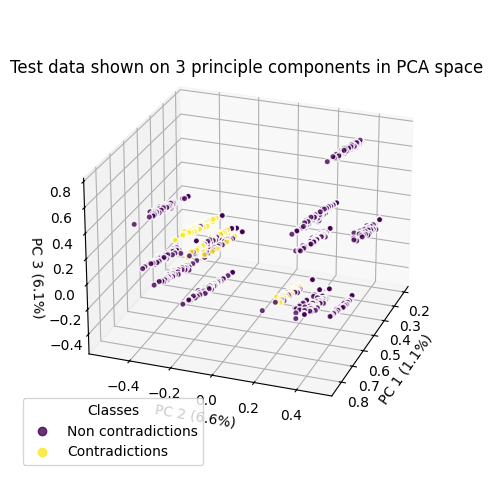

Total variance explained by first 3 principle components: 13.86%


In [116]:
svd = TruncatedSVD(n_components=3)
embedded_data = svd.fit_transform(test_data_vectorized)

variances = svd.explained_variance_ratio_
total_var = variances.sum() * 100

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
	embedded_data[:, 0], 
	embedded_data[:, 1], 
	embedded_data[:, 2], 
	c=predictions, 
	cmap='viridis', 
	s=20, 
	alpha=0.8,
	edgecolor="white"
)

ax.set_title("Test data shown on 3 principle components in PCA space", y=0.92)

ax.set_xlabel(f'PC 1 ({variances[0]:.1%})')
ax.set_ylabel(f'PC 2 ({variances[1]:.1%})')
ax.set_zlabel(f'PC 3 ({variances[2]:.1%})')
ax.set_box_aspect(None, zoom=0.85)

ax.view_init(elev=25, azim=20) 

class_names = ["Non contradictions", "Contradictions"]
handles, _ = scatter.legend_elements()
ax.legend(
	handles, 
	class_names, 
	loc="lower left", 
	title="Classes"
)

plt.show()

print(f"Total variance explained by first 3 principle components: {total_var:.2f}%")

The performance seemed suspicious so we choose to plot the data. We plotted it by using PCA and reducing Tf-Idf vectors to 3 components. We can see some patterns. Contradictions are usually in some line close together. We can't say much more as we don't explain much of the variance on just first 3 principle components. 

## Transformer-Based Classifier

For the third part of the assignment we were tasked to train a transformer based classifier. We choose to split this part of the report into training and evaluation parts. We will show the training only for our best model as code repeats for each of them. The specifics will be talked about in the evaluation section. 

### Training

To train we chosen longformer-mini-1024 model. We choose it for it's 1024 tokens long context window. We choose mini model for faster training time. The time it took to train 1 epoch was about 3 hours. 

In [57]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset

def preprocess_function(examples):
	inputs = tokenizer(examples["premise"], examples["hypothesis"], 
			max_length=1024, truncation="only_first", padding="max_length")

	global_attention_mask = [[0] * len(ids) for ids in inputs["input_ids"]]

	for mask in global_attention_mask:
		mask[0] = 1 
		
	inputs["global_attention_mask"] = global_attention_mask
	return inputs

model_name = "kiddothe2b/longformer-mini-1024"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at kiddothe2b/longformer-mini-1024 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The function above shows how we preprocess the text. If the tokens exceed max length we truncate the premise. Keeping the premise intact. We also set every token to use local attention except the first one, that will store the global attention of the sentence. 

In [ ]:
train_dataset = Dataset.from_pandas(train_data)
tokenized_train_dataset = train_dataset.map(preprocess_function, batched=True)

dataset_split = tokenized_train_dataset.train_test_split(test_size=0.1)
tokenized_train_dataset = dataset_split["train"]
tokenized_eval_dataset = dataset_split["test"]

test_dataset = Dataset.from_pandas(test_data)
tokenized_test_dataset = test_dataset.map(preprocess_function, batched=True)

Map: 100%|██████████| 2091/2091 [00:02<00:00, 814.66 examples/s]


We split the train dataset into train and evaluation dataset with the ration of 9:1. Evaluation dataset we will use in training to choose the best model. 

In [ ]:
RUN = False

from transformers import TrainingArguments, Trainer
from sklearn.metrics import f1_score
from torch import nn

class WeightedTrainer(Trainer):
	def __init__(self, *args, class_weights=None, **kwargs):
		super().__init__(*args, **kwargs)
		if class_weights is not None:
			self.class_weights = torch.tensor(class_weights, dtype=torch.float).to(self.args.device)
		else:
			self.class_weights = None

	def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None, **kwargs):
		labels = inputs.get("labels")
		outputs = model(**inputs)
		logits = outputs.get("logits")
		
		if self.class_weights is not None:
			loss_fct = nn.CrossEntropyLoss(weight=self.class_weights)
			loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
		else:
			# Fallback to default loss if no weights are provided
			loss = outputs.loss if isinstance(outputs, dict) else outputs[0]
			
		return (loss, outputs) if return_outputs else loss

def compute_metrics(eval_pred):
	logits, labels = eval_pred
	predictions = np.argmax(logits, axis=-1)

	f1 = f1_score(labels, predictions, pos_label=1, average='binary')
	return {"f1_score_class_1": f1}

class_weights = [1.0, 9.0] # Weight class 0, weight class 1

training_args = TrainingArguments(
	output_dir="./artifacts",
	learning_rate=2e-4,
	per_device_train_batch_size=2,
	gradient_accumulation_steps=16,
	num_train_epochs=2,
	weight_decay=0.01,
	save_strategy="steps",
	save_steps=50,
	save_total_limit=3, 
	load_best_model_at_end=True,
	metric_for_best_model="f1_score_class_1", 
	eval_strategy="steps",
	eval_steps=50,
	greater_is_better=True,
	resume_from_checkpoint=False
)


path = "./trained_model_ex3_f1_class1_weighted"
if (not os.path.exists(path) and RUN):
	trainer = WeightedTrainer(
		model=model,
		args=training_args,
		train_dataset=tokenized_train_dataset,
		eval_dataset=tokenized_eval_dataset,
		compute_metrics=compute_metrics,
		class_weights=class_weights,
	)

	trainer.train(resume_from_checkpoint=True)

	tokenizer.save_pretrained(path)
	trainer.save_model(path)
else:
	print("Model not trained")

Model not trained


Because there the training data is unbalanced we need to help the contradiction class (so we don't accidentally create majority classifier). For this reason we added class weights. The contradiction class is at weight ratio of 9:1. These weights just worked the best in testing. 

### Evaluation

Here we talk about all models that we built. 

In [ ]:
path = "trained_model_ex3_v2_macro_f1_v1"
if (os.path.exists(path)):
	model = AutoModelForSequenceClassification.from_pretrained(path, num_labels=2)

	trainer = Trainer(model=model)
	predictions_procentages = trainer.predict(tokenized_test_dataset)[0]
	predictions = predictions_procentages.argmax(-1)
	report_dict = classification_report(test_data["label"], predictions, zero_division=0, output_dict=True)
	pretty_print_report_dict(report_dict)
else:
	print("Model not found")

c:\Users\timna\Desktop\ISsem2_Cmpy\SkupnoAng\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


CLASS PERFORMANCE
┏━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃    ┃  precision  ┃  recall  ┃  f1-score  ┃  support  ┃
┣━━━━╋━━━━━━━━━━━━━╋━━━━━━━━━━╋━━━━━━━━━━━━╋━━━━━━━━━━━┫
┃ 0  ┃    0.935    ┃  0.975   ┃   0.955    ┃   1871    ┃
┃ 1  ┃    0.667    ┃  0.427   ┃   0.521    ┃    220    ┃
┗━━━━┻━━━━━━━━━━━━━┻━━━━━━━━━━┻━━━━━━━━━━━━┻━━━━━━━━━━━┛

GLOBAL AVERAGES
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━┓
┃              ┃  precision  ┃  recall  ┃  f1-score  ┃
┣━━━━━━━━━━━━━━╋━━━━━━━━━━━━━╋━━━━━━━━━━╋━━━━━━━━━━━━┫
┃ accuracy     ┃    0.917    ┃  0.917   ┃   0.917    ┃
┃ macro avg    ┃    0.801    ┃  0.701   ┃   0.738    ┃
┃ weighted avg ┃    0.907    ┃  0.917   ┃   0.909    ┃
┗━━━━━━━━━━━━━━┻━━━━━━━━━━━━━┻━━━━━━━━━━┻━━━━━━━━━━━━┛


This was the second model that we built. First one turned into majority classifier. We were training this model on macro F1 score (to help with imbalanced dataset) and we didn't use any weights. Our goal was to defeat it. 

In [ ]:
path = "trained_model_ex3_precision_class1_v1"
if (os.path.exists(path)):
	model = AutoModelForSequenceClassification.from_pretrained(path, num_labels=2)

	trainer = Trainer(model=model)
	predictions_procentages = trainer.predict(tokenized_test_dataset)[0]
	predictions = predictions_procentages.argmax(-1)
	report_dict = classification_report(test_data["label"], predictions, zero_division=0, output_dict=True)
	pretty_print_report_dict(report_dict)
else:
	print("Model not found")

c:\Users\timna\Desktop\ISsem2_Cmpy\SkupnoAng\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


CLASS PERFORMANCE
┏━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃    ┃  precision  ┃  recall  ┃  f1-score  ┃  support  ┃
┣━━━━╋━━━━━━━━━━━━━╋━━━━━━━━━━╋━━━━━━━━━━━━╋━━━━━━━━━━━┫
┃ 0  ┃    0.981    ┃  0.972   ┃   0.976    ┃   1871    ┃
┃ 1  ┃    0.776    ┃  0.836   ┃   0.805    ┃    220    ┃
┗━━━━┻━━━━━━━━━━━━━┻━━━━━━━━━━┻━━━━━━━━━━━━┻━━━━━━━━━━━┛

GLOBAL AVERAGES
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━┓
┃              ┃  precision  ┃  recall  ┃  f1-score  ┃
┣━━━━━━━━━━━━━━╋━━━━━━━━━━━━━╋━━━━━━━━━━╋━━━━━━━━━━━━┫
┃ accuracy     ┃    0.957    ┃  0.957   ┃   0.957    ┃
┃ macro avg    ┃    0.878    ┃  0.904   ┃   0.891    ┃
┃ weighted avg ┃    0.959    ┃  0.957   ┃   0.958    ┃
┗━━━━━━━━━━━━━━┻━━━━━━━━━━━━━┻━━━━━━━━━━┻━━━━━━━━━━━━┛


First idea was to change the loss function. Our thinking was that if we change it into class 1 specific one it would help raise it up and with it all the other metrics. So we changed into precision in class 1. This is the first model we designated as not a failure. Ideally we wanted all scores above 0.8. 

In [ ]:
path = "trained_model_ex3_f1_class1_weighted"
if (os.path.exists(path)):
	model = AutoModelForSequenceClassification.from_pretrained(path, num_labels=2)

	trainer = Trainer(model=model)
	predictions_procentages = trainer.predict(tokenized_test_dataset)[0]
	predictions = predictions_procentages.argmax(-1)
	report_dict = classification_report(test_data["label"], predictions, zero_division=0, output_dict=True)
	pretty_print_report_dict(report_dict)
else:
	print("Model not found")

c:\Users\timna\Desktop\ISsem2_Cmpy\SkupnoAng\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


CLASS PERFORMANCE
┏━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃    ┃  precision  ┃  recall  ┃  f1-score  ┃  support  ┃
┣━━━━╋━━━━━━━━━━━━━╋━━━━━━━━━━╋━━━━━━━━━━━━╋━━━━━━━━━━━┫
┃ 0  ┃    0.981    ┃  0.975   ┃   0.978    ┃   1871    ┃
┃ 1  ┃    0.797    ┃  0.836   ┃   0.816    ┃    220    ┃
┗━━━━┻━━━━━━━━━━━━━┻━━━━━━━━━━┻━━━━━━━━━━━━┻━━━━━━━━━━━┛

GLOBAL AVERAGES
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━┓
┃              ┃  precision  ┃  recall  ┃  f1-score  ┃
┣━━━━━━━━━━━━━━╋━━━━━━━━━━━━━╋━━━━━━━━━━╋━━━━━━━━━━━━┫
┃ accuracy     ┃    0.96     ┃   0.96   ┃    0.96    ┃
┃ macro avg    ┃    0.889    ┃  0.906   ┃   0.897    ┃
┃ weighted avg ┃    0.961    ┃   0.96   ┃   0.961    ┃
┗━━━━━━━━━━━━━━┻━━━━━━━━━━━━━┻━━━━━━━━━━┻━━━━━━━━━━━━┛


In this model we changed the loss function to f1 score in class 1. This was to make it more "balanced" in regards to scores. This was also first model that we used weights with. We choose 9:1 ratio as explained in the training part of this assignment. The scores approved, but we were without ideas what to do next, so we decided to try to train it for longer. 

In [ ]:
path = "trained_model_ex3_f1_class1_weighted_2_epoc"
if (os.path.exists(path)):
	model = AutoModelForSequenceClassification.from_pretrained(path, num_labels=2)

	trainer = Trainer(model=model)
	predictions_procentages = trainer.predict(tokenized_test_dataset)[0]
	predictions = predictions_procentages.argmax(-1)
	report_dict = classification_report(test_data["label"], predictions, zero_division=0, output_dict=True)
	pretty_print_report_dict(report_dict)
else:
	print("Model not found")

c:\Users\timna\Desktop\ISsem2_Cmpy\SkupnoAng\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


CLASS PERFORMANCE
┏━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃    ┃  precision  ┃  recall  ┃  f1-score  ┃  support  ┃
┣━━━━╋━━━━━━━━━━━━━╋━━━━━━━━━━╋━━━━━━━━━━━━╋━━━━━━━━━━━┫
┃ 0  ┃    0.982    ┃  0.974   ┃   0.978    ┃   1871    ┃
┃ 1  ┃    0.791    ┃  0.845   ┃   0.818    ┃    220    ┃
┗━━━━┻━━━━━━━━━━━━━┻━━━━━━━━━━┻━━━━━━━━━━━━┻━━━━━━━━━━━┛

GLOBAL AVERAGES
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━┓
┃              ┃  precision  ┃  recall  ┃  f1-score  ┃
┣━━━━━━━━━━━━━━╋━━━━━━━━━━━━━╋━━━━━━━━━━╋━━━━━━━━━━━━┫
┃ accuracy     ┃    0.96     ┃   0.96   ┃    0.96    ┃
┃ macro avg    ┃    0.887    ┃   0.91   ┃   0.898    ┃
┃ weighted avg ┃    0.962    ┃   0.96   ┃   0.961    ┃
┗━━━━━━━━━━━━━━┻━━━━━━━━━━━━━┻━━━━━━━━━━┻━━━━━━━━━━━━┛


By training it for an extra epoch the scores barely incised. We remembered the law of diminishing returns and called it a day. 

## Sentence Embedding Model for Contradiction Search

While our proposed classifiers yielded good results, comparing the entire legal corpus with a hypothesis is wasteful. We can improve this by only checking for contradictions on the first k most likely contradictory sections. To find those k sections we need a retriever. A sentence transformer model which embeds legal texts, so that contradictory sections lie close, in the vector space.

For this we needed a model that understands English, needs to accept text of length 1000, which is around the length of the longest premises. And is lightweight enough to be easily fine tuned and ran on worse hardware. jina-embeddings-v2-small-en, was the model that was chosen based on this criteria and will be the model used in this section for the purposes of retrieval.

## Loss function and data preperation

The main concerns in this part, was the structure of the training data and the accompanying loss function. The important features of the dataset that affected this choice most, were having our data labeled with discreet classes, and the imbalance of our dataset. Because of that we focused on structuring the data for the Contrastive Lost and Multiple Negatives Ranking Loss(MNRL). Both of them work on data with binary classification, but more importantly they also take into account the negative samples, which is important, due to the small number of positive examples in the dataset. While training on positive samples will allow us to group contradictory sections together, negative examples can push non contradictory sections away from each other.

Our data is already in the perfect format for Contrastive loss. As it requires a query answer pair, with a binary label, which is what we've already prepared in previous sections. 

In [18]:
def filter_neg(data, model, params):
    d = {'hypothesis':[], 'premise':[]}
    for k in range(len(data)):
        if data['label'][k] == 1:
            d['hypothesis'].append(data['hypothesis'][k])
            d['premise'].append(data['premise'][k])
    ret = Dataset.from_dict(d)
    return (ret, None)

In [155]:
import random
from datasets import Dataset
from datasets import Dataset
from sentence_transformers.data_collator import SentenceTransformerDataCollator
from torch._tensor import Tensor
from typing import Any

class MyDataCollator(SentenceTransformerDataCollator): # We need this so we can insert negatives to the batches
    universal_negatives = ['', '']
    negatives_per_batch = 4

    def __call__(self, features: list[dict[str, Any]]) -> dict[str, Tensor]:
        k = list(features[0].keys())[1]
        for i, feature in enumerate(features):
            features[i][k] = [features[i][k]] + random.sample(
            self.universal_negatives, 
            min(self.negatives_per_batch, len(self.universal_negatives))
        )
        #print(features[i][k])
        batch = super().__call__(features)
        return batch

def get_data_col(data, model, params):
    h = len(set(data['hypothesis']))
    p = len(set(data['premise']))
    
    hmm = dict(zip(set(data['premise']), [0]*p))
    d = {'hypothesis':[], 'premise':[]}
    for k in range(len(data)):
        if data['label'][k] == 1:
            d['hypothesis'].append(data['hypothesis'][k])
            d['premise'].append(data['premise'][k])
        else:
            hmm[data['premise'][k]] += 1
    universal_negatives = []
    for k, v in hmm.items():
        if v >= h: 
            universal_negatives.append(k) # if this premise is negative for all hypothesis
    
    data = Dataset.from_dict(d)
    data_collator = MyDataCollator(model.tokenize)
    data_collator.universal_negatives = universal_negatives
    data_collator.negatives_per_batch = params['negatives_per_batch']

    return data, data_collator

def get_data_col_improved(data, model, params):
    h = len(set(data['hypothesis']))
    p = len(set(data['premise']))
    
    hmm = dict(zip(set(data['premise']), [0]*p))
    num_pozitives = dict(zip(set(data['hypothesis']), [0]*p))
    d = {'hypothesis':[], 'premise':[]}
    for k in range(len(data)):
        if data['label'][k] == 1:
            d['hypothesis'].append(data['hypothesis'][k])
            d['premise'].append(data['premise'][k])
            num_pozitives[data['hypothesis'][k]] += 1
        else:
            hmm[data['premise'][k]] += 1
    universal_negatives = []

    for k, v in hmm.items():
        if v >= h: 
            universal_negatives.append(k) # if this premise is negative for all hypothesis
    
    for k in set(data['hypothesis']):
        if num_pozitives[k] < 1:
            for i in range(4):
                d['hypothesis'].append(k)
                d['premise'].append(k)

    data = Dataset.from_dict(d)
    data_collator = MyDataCollator(model.tokenize)
    data_collator.universal_negatives = universal_negatives
    data_collator.negatives_per_batch = params['negatives_per_batch']

    return data, data_collator


For MNRL more work was needed. This loss accepts a tuple of strings. The first being the query, second item the correct answer, the rest being negatives. When training in batches, which is usually the case, this loss also takes the positive answer from all the other examples in the batch as a negative answer. 

As hypothesis can be contradictory with multiple premises, we needed to ensure as few positives were mistakenly taken as a negative as possible. This was done by passing the NO_DUPLICATES argument to the trainer. This doesn't remove this problem completely, but is usually enough. (If two hypothesis, contradict the same premise, it is possible that, in some batch on hypothesis will be incorrectly moved away from that premise ). Having 0 appended negatives isn't really an option as a large number of premises aren't contradictory to any of the 17 hypothesis.


After testing 1,2 and 3, we continued with 3 negatives in each anchor positive pair, after it showed the best results. Directly appending the 3 negatives to each pair would drastically increase the size of the dataset. Instead of doing that we inserted a random quartet of negative examples, to each positive pair using a custom data collator class.

In [251]:
ls = {}

h = list(set(train_dataset['hypothesis']))
h.sort() # i want to ensure a constant order
for i in h:
    ls[i] = 0

for k in range(len(train_dataset)):
    if train_dataset['label'][k] > 0:
        ls[train_dataset['hypothesis'][k]] += 1
ls = [v for k,v in ls.items()]
print(ls)

[0, 93, 2, 267, 0, 69, 0, 172, 11, 92, 1, 1, 1, 0, 4, 0, 11]


The outputed list above shows as the number of contradicting premises each of the hypothesis in the training data has. We can see that the this number is quite variable, which might cause trouble with the MNLR method, as the hypothesis with no contradictions will never show up in its training data, as MNLR only works on positive examples (with appended negatives). If we get unlucky, the number of hypothesis without positive examples could be even bigger, if we get an unlucky validation/training split. To account for, when a hypothesis has no contradicting pair, we pair it with itself. While this is the opposite of a contradiction, we hope that the model learns to move these examples away from the premises we know don't contradict it. This model can't use the no duplicates batch sampler, as we want the training data to have duplicates in certain conditions. If this causes a problem we could later try a custom batch sampler.

In the continuation we will refer to these models as:
- the model cl (uses contrastive loss), 
- model mnrl (uses MNLR with appended negatives) and 
- model mnlr improved (which tries to account for a lack of contradicting examples in the training data)

### Parameters

In [250]:
def search_space(trial):
    return {
        'learning_rate': trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True),
        'weight_decay': trial.suggest_float("weight_decay", 0.01, 0.1),
        "warmup_ratio": trial.suggest_float("warmup_ratio", 0.05, 0.2),
        'max_grad_norm': trial.suggest_float("max_grad_norm", 0.5, 1.0, log=True),
        'num_train_epochs': trial.suggest_int("num_train_epochs", 1, 10),
    }

The hyper parameters for each model we tested were found using a hyper parameter search. The function above defines the search space for the hyper parameters we chose to optimize

#### Setting the parameters

In [136]:
from sentence_transformers.training_args import SentenceTransformerTrainingArguments

args = SentenceTransformerTrainingArguments(
    # Required parameter:
    output_dir="models/checkpoints",
    # Optional training parameters:
    num_train_epochs=1,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=1.2247359733257542e-05,
    seed=42,
    metric_for_best_model=f"eval_cosine_recall@10",
    load_best_model_at_end=True,
    weight_decay=0.09092585204374326,
    warmup_ratio=0.05503071687326718,
    batch_sampler=None,
    #batch_sampler=BatchSamplers.NO_DUPLICATES,  # losses that use "in-batch negatives" benefit from no duplicates
    # Optional tracking/debugging parameters:
    eval_strategy="steps",
    eval_steps=100,
    torch_empty_cache_steps = None,
    save_steps=100,
    save_total_limit=2,
    max_grad_norm= 0.8774817671930895,
    logging_steps=100,
    log_level="warning"
)

In [183]:
from sentence_transformers.training_args import BatchSamplers

args_mnlr = SentenceTransformerTrainingArguments(
    # Required parameter:
    output_dir="models/checkpoints",
    # Optional training parameters:
    num_train_epochs=30,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=4.890585631921125e-05,
    seed=42,
    metric_for_best_model=f"eval_cosine_recall@10",
    #load_best_model_at_end=True,
    weight_decay=0.010800797401617856,
    warmup_ratio=0.0765080638605733,
    batch_sampler=BatchSamplers.NO_DUPLICATES,  # losses that use "in-batch negatives" benefit from no duplicates
    # Optional tracking/debugging parameters:
    eval_strategy="steps",
    eval_steps=100,
    torch_empty_cache_steps = None,
    max_grad_norm= 0.5013390304609416,
    logging_steps=100,
    log_level="warning"
)

args_mnlr_improved = SentenceTransformerTrainingArguments(
    # Required parameter:
    output_dir="models/checkpoints",
    # Optional training parameters:
    num_train_epochs=30,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=4.890585631921125e-05,
    seed=42,
    metric_for_best_model=f"eval_cosine_recall@10",
    #load_best_model_at_end=True,
    weight_decay=0.010800797401617856,
    warmup_ratio=0.0765080638605733,
    #batch_sampler=BatchSamplers.NO_DUPLICATES,  # we need to allow duplicates here, hopefully this won't cause problems
    # Optional tracking/debugging parameters:
    eval_strategy="steps",
    eval_steps=100,
    torch_empty_cache_steps = None,
    max_grad_norm= 0.5013390304609416,
    logging_steps=100,
    log_level="warning"
)

In [178]:
from copy import deepcopy
def hyper_search(train_dataset, valid_dataset, model_kwargs):
    dev_evaluator = get_ret_eval(valid_dataset, name="sts-dev")
    model_kwargs = deepcopy(model_kwargs)
    # 7. Define the training arguments
    hpo_args = SentenceTransformerTrainingArguments(
        # Required parameter:
        num_train_epochs=1.0,
        per_device_train_batch_size=16,
        seed=42,
        metric_for_best_model=f"eval_cosine_recall@10",
        output_dir="checkpoints",
        batch_sampler=BatchSamplers.NO_DUPLICATES, # Remove if searching for the Contrastive loss or triplet model
        # Optional tracking/debugging parameters:
        eval_strategy="no", # We don't need to evaluate/save during HPO
        save_strategy="no",
        logging_steps=40,
        run_name="hpo",  # Will be used in W&B if `wandb` is installed
        
    )
    model_kwargs['args'] = hpo_args
    trainer = get_trainer(train_dataset, valid_dataset, evaluator=dev_evaluator, **model_kwargs)

    best_trial = trainer.hyperparameter_search(
        hp_space=search_space,
        compute_objective=hpo_compute_objective,
        n_trials=25,
        direction="maximize",
        backend="optuna",

    )
    print(best_trial)

In [209]:
from sentence_transformers.losses import ContrastiveLoss, MultipleNegativesRankingLoss

base_model_kwargs = {"trained_model_path":"models\jina-embeddings-v2-small-en", 'name':'base model'}

# model from task 3
model_classifier = {"trained_model_path":"models/main3_pretrained", 'name':'task 3'} # just for testing was trained in task 3

# Kinda bad, and slow but simple
model_cl_kwargs = {"trained_model_path":"models/trained/model_cl", "loss": cl_loss_init, "args":args, "model_init":model_init, 'name':'cl'}

model_mnlr_kwargs = {
    "trained_model_path":"models/trained/model_mnlr2_test", # the trained model will be both loaded from here and saved from here
    "loss":mnlr_loss_init, 
    "args":args_mnlr, 
    "data_preprocesser": get_data_col, # This method returns both the restrucured train data, and the data collator for it
    "params": {"negatives_per_batch":3}, # parameters for get_data_col
    "model_init":model_init, # the base model that wasn't yet fine tuned
    'name':'mnlr'
    }

model_mnlr_improved_kwargs = {
    "trained_model_path":'models\checkpoints\checkpoint-1290', # the trained model will be both loaded from here and saved from here
    "loss":mnlr_loss_init, 
    "args":args_mnlr_improved, 
    "data_preprocesser": get_data_col_improved, # This method returns both the restrucured train data, and the data collator for it
    "params": {"negatives_per_batch":2}, # parameters for get_data_col
    "model_init":model_init, # the base model that wasn't yet fine tuned
    'name':'mnlr improved'
    }


models = [base_model_kwargs, model_classifier, model_cl_kwargs, model_mnlr_kwargs, model_mnlr_improved_kwargs]

## Evaluation of the models

In [107]:
train_dataset, valid_dataset, test_dataset = get_data(valid_split=0.1)

In [ ]:
if TRAIN:
    train(train_dataset, valid_dataset, model_cl_kwargs)
    train(train_dataset, valid_dataset, model_mnlr_kwargs)
    train(train_dataset, valid_dataset, model_mnlr_improved_kwargs)

In [218]:
from collections import OrderedDict
ev = MyRecallEval(test_dataset)

mistakes_dist = []
results = []
for m_kwargs in models: # the model from task 3 uses a different model
    m = SentenceTransformer(m_kwargs['trained_model_path'])
    mistakes_dist.append(ev.get_and_clear_mistakes_info())
    d = OrderedDict()
    d['name'] = m_kwargs['name']
    d.update(ev(m))
    results.append(d)

Some weights of BertModel were not initialized from the model checkpoint at models\jina-embeddings-v2-small-en and are newly initialized: ['embeddings.position_embeddings.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.0.output.LayerNorm.weight', 'encoder.layer.0.output.dense.bias', 'encoder.layer.0.output.dense.weight', 'encoder.layer.1.intermediate.dense.bias', 'encoder.layer.1.intermediate.dense.weight', 'encoder.layer.1.output.LayerNorm.bias', 'encoder.layer.1.output.LayerNorm.weight', 'encoder.layer.1.output.dense.bias', 'encoder.layer.1.output.dense.weight', 'encoder.layer.2.intermediate.dense.bias', 'encoder.layer.2.intermediate.dense.weight', 'encoder.layer.2.output.LayerNorm.bias', 'encoder.layer.2.output.LayerNorm.weight', 'encoder.layer.2.output.dense.bias', 'encoder.layer.2.output.dense.weight', 'encoder.layer.3.intermediate.dense.bias', 'encoder.layer.3.intermediate.den

In [248]:
print(tabulate(results, headers='keys', tablefmt='heavy_outline', numalign="center"))

┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ name          ┃  recall@10  ┃  hit_rate  ┃
┣━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━╋━━━━━━━━━━━━┫
┃ base model    ┃    0.01     ┃    0.1     ┃
┃ task 3        ┃  0.061619   ┃    0.4     ┃
┃ cl            ┃  0.0526357  ┃    0.3     ┃
┃ mnlr          ┃  0.197731   ┃    0.7     ┃
┃ mnlr improved ┃  0.149846   ┃    0.8     ┃
┗━━━━━━━━━━━━━━━┻━━━━━━━━━━━━━┻━━━━━━━━━━━━┛


From this table it can clearly be seen that the mnlt models outperform the cl model. Important to note while the two MNLR models were trained for far more epochs then the rest, each of its epochs are much smaller due to only including positive pairs, with added negatives. The mnlr model took 3 times less time to train than the cl and mnlr improved models. Both mnlr models were trained in less then 2000 steps, while the cl model took over 6000.

*Note:* 0.65 is the highest recall@10 that can be achived.

Recall@10 was chosen as the main evaluation metric of such a model. We have decided to retrieve the 10 most similar texts to the hypothesis, from the corpus, though that number can still be increased or decreased. Reacall@10 measuring what % of all the relevant sections were present in the answer. This is the main thing we care about, we want as many contradictory sections as possible in the top 10, to give the classifying model the highest chance of making the correct prediction. The mnlr model reaches the highest on in this metric

The secondary metric we paid attention to was hit rate. Which is the likelyhood that the model returns a atleast one contradiction among the top 10 most simmilar premises to the given hypothesis. Here the mnlr improved model had a higher score.

The mnlr model is the best out of the models we evaluated. Mnlr improved model might have a higher hitrate, but as we only have 10 hypothesis with contradictions in the test dataset, we can't say that this is a substantial improvment.

The base model, is the untrained model. As we can see in the table, its results are much worse showing that our fine tuning did bring contradicting statments closer, and pushed non-contradicting further away.

### Analysis of the mistakes

In [220]:
mist = [v for k,v in mistakes_dist[-1].items()]
print(mist)

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0]


The above shows for which 3 hypothesis the model was unable to find a contradiction.

[0, 93, 2, 267, 0, 69, 0, 172, 11, 92, 1, 1, 1, 0, 4, 0, 11]

above the number of contradictions in the training dataset per hypothesis

We can see that the fewer times a hypothesis is seen during training the worse performance our mnlr model will have when dealing with this hypothesis. Which is expected, however it would be more desirable if the model could generalize to previously unseen hypothesis.

## Adding the model from task 3 to the pipeline

Finally we created a pipeline for finding contradictions, to a new law, based on previously loaded and embedded corpus of data. This pipeline takes a string(or a list of strings) as an input, checks the entire corpus, finds the 10 most likely sections that would contradict it, using the retriever from task 4. Using the classifier from task 3, we then classify these 10 premises, paired with the hypothesis, and return those pairs that were classified as a contradiction.

In [ ]:
def preprocess_function(examples):
	inputs = tokenizer(examples["premise"], examples["hypothesis"], 
			max_length=1024, truncation="only_first", padding="max_length")

	global_attention_mask = [[0] * len(ids) for ids in inputs["input_ids"]]

	for mask in global_attention_mask:
		mask[0] = 1 
		
	inputs["global_attention_mask"] = global_attention_mask
	return inputs

model_name = "kiddothe2b/longformer-mini-1024"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

In [242]:
from sentence_transformers import util
import numpy as np
from numpy import hstack

class OurClassifier:
    def __init__(self, retriever, final_classifier, tokenizer, corpus, k):
        self.retriever = retriever
        self.final_classifier = final_classifier
        self.tokenizer = tokenizer
        self.corpus = corpus
        self.embeded_corpus = self.retriever.encode(corpus, convert_to_tensor=True)
        self.k = min(len(corpus), k)

    def predict(self, x):
        embedded_x = self.retriever.encode(x, convert_to_tensor=True)
        top_k = util.semantic_search(embedded_x, self.embeded_corpus, top_k=self.k, score_function=self.retriever.similarity)
        candidates_premises = []
        candidates_hypotheses = []

        for query_id, query in enumerate(x):
            
            # Prepare all candidates for this query
            for res in top_k[query_id]:
                corpus_id = res['corpus_id']
                candidates_premises.append(self.corpus[corpus_id])
                candidates_hypotheses.append(query)
            
        if candidates_premises:
            # Create the dictionary format that single_preprocess_function expects
            candidates = {
                "premise": candidates_premises,
                "hypothesis": candidates_hypotheses
            }
            candidates = Dataset.from_dict(candidates)
            candidates = candidates.map(preprocess_function, batched=True)
            
            result = self.final_classifier.predict(candidates)
            batch_predictions = result.predictions
            
            contradictions = {}
            for q in x:
                contradictions[q] = []
            # Convert logits to class predictions
            if batch_predictions.ndim > 1:  # If it's logits
                batch_predictions = np.argmax(batch_predictions, axis=1)
        
            for res, premise, hyp in zip(batch_predictions, candidates_premises, candidates_hypotheses):
                if res > 0:
                    contradictions[hyp].append(premise)
        
        return contradictions

In [243]:
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
model_name = "models/trained_model_ex3_f1_class1_weighted_2_epoc" # model from task 3
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = Trainer(model=AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2))
retr = SentenceTransformer(model_mnlr_kwargs['trained_model_path'])
m = OurClassifier(retr, model, tokenizer, np.array(list(set(test_dataset['premise']))), k=10)

In [ ]:
predictions = m.predict(list(set(test_dataset['hypothesis'])))

In [245]:
h = list(set(test_dataset['hypothesis']))
h.sort()
predictions_count = [len(predictions[k]) for k in h]
print(predictions_count)

[0, 9, 0, 10, 0, 4, 0, 9, 2, 3, 0, 0, 0, 0, 0, 0, 0]


Finnaly we'll list the premises that contradict the fourth hypothesis:

In [258]:
print("hypothesis:", h[3])
for p in predictions[h[3]]:
    print(p)

hypothesis: Confidential Information shall only include technical information.
Confidential Information includes, but is not limited to documents, drawings, models, apparatus, sketches, designs, schedules, product plans, marketing plans, technical procedures, manufacturing processes, software, prototypes, samples, methodologies, formulations, trade secrets, patent applications, know-how, experimental results, specifications and other business information.
3. The term "Information" shall include all written information, verbal or otherwise presented in tangible or intangible way, including, but not limited to, trade secrets, discoveries, ideas, concepts, know-how, techniques, technology, products, designs, specifications, drawings, diagrams, data, computer programs, business activities and operations, reports, studies and other technical, commercial, financial information of each Party or its Affiliates.
Confidential Information includes, but is not limited to, the following types of in

# Results and discussion

In this report we discussed the detection of contradictory statments in legal documents. In task 2 we applied traditional machine learning methods to this task, and were suprised by their effectivnes. Finding SVM to be the most effective. When plotting the vectors to a 3 dimensional space, we found that contradictions usually group togather along lines in the space.
In task 3 we fine tuned a model on the dataset. Our best model with weighted classes, performed slightly worse than the SVM model from task 2.
In task 4 we fine tuned a retriever. We showed that it did group contradictions closer togather, however we found it had trouble generalizing to less seen hypothesis.
Finnaly we joined the models, and showed how to use them togather to retrieve possibly contradicting statments from a corpus of legal text, given a hypothesis.